# Lab 2 Universal Style Transfer

Student name： Bochuan Wu  Student ID：47497181

#  1.The backgroud of universal style transer 

Traditional neural style transfer has two big drawbacks: parameter adjustment/time-consuming.

That is to say, not only do we need to adjust the parameters of the hierarchy of neural style, but also the whole iteration process is to iterate for Z noise, which is very time-consuming.
So that the authors in the field of style transfer have been thinking about the possibility of generalizing the feature style transfer through encoder / decoder for style transfer.

For this Universal Style Transfer via Feature Transforms paper, it proposes a general reconstruction network, which can transfer any input style without requiring retraining.


# 2.The main idea of this paper

1. It proposes a WTC layer（whitening & coloring transform layer）: For any input style image,it can enable content to display style, only need the feature map hierarchical distribution representation is consistent.

    1.Firstly, feature map is subtracted from the mean value, and then multiplied by the inverse matrix of its covariance matrix, use whitening to pull feature map into a whitened distribution space.
    2.Then color covariance matrix of image feature map is obtained by style image. Multiply the whitened result of content image and add mean, which migrates the whitened feature map space to the distribution of style map.
    3.Iterate up and finally decode out the result.
    
2. It trained a general decoder to decode feature map after WCT.


# 3.Build a VGG-19 model as Encoder

In [1]:
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, Input
from keras.utils.data_utils import get_file
import keras.backend as K
import h5py
import numpy as np
import tensorflow as tf
#address of Pre-trained weights
WEIGHTS_PATH = './vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
def vgg_layers(inputs, target_layer):
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(inputs)
    if target_layer == 1:
        return x
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    if target_layer == 2:
        return x
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    if target_layer == 3:
        return x
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    if target_layer == 4:
        return x
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    return x


def load_weights(model):
    f = h5py.File(WEIGHTS_PATH)
    layer_names = [name for name in f.attrs['layer_names']]

    for layer in model.layers:
        b_name = layer.name.encode()
        if b_name in layer_names:
            g = f[b_name]
            weights = [g[name] for name in g.attrs['weight_names']]
            layer.set_weights(weights)
            layer.trainable = False

    f.close()


def VGG19(input_tensor=None, input_shape=None, target_layer=1):
    """
    VGG19, up to the target layer (1 for relu1_1, 2 for relu2_1, etc.)
    """
    if input_tensor is None:
        inputs = Input(shape=input_shape)
    else:
        inputs = Input(tensor=input_tensor, shape=input_shape)
    model = Model(inputs, vgg_layers(inputs, target_layer), name='vgg19')
    load_weights(model)
    return model


def preprocess_input(x):
    # Convert 'RGB' -> 'BGR'
    if type(x) is np.ndarray:
        x = x[..., ::-1]
    else:
        x = tf.reverse(x, [-1])

    return x - MEAN_PIXEL

Using TensorFlow backend.


Implement the whitening and coloring transform as described by Li et al. An implementation of this has already been written for you, available in the link above. Show a few images that are style transferred using this method. For better numerical stability, you may use an SVD decomposition rather than an Eigen Decomposition.

# 4.Build the decoder layer without the final conv layer

In [3]:
from keras.layers import Input, Conv2D, UpSampling2D

def decoder_layers(inputs, layer):
    if layer > 4:
        x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block5_conv1')(inputs)
        x = UpSampling2D((2, 2), name='decoder_block4_upsample')(x)
        x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv4')(x)
        x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv3')(x)
        x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv2')(x)
        x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv1')(x)
        
        x = UpSampling2D((2, 2), name='decoder_block3_upsample')(x)
        x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv4')(x)
        x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv3')(x)
        x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv2')(x)
    elif layer > 3:
        x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv1')(inputs)
        x = UpSampling2D((2, 2), name='decoder_block3_upsample')(x)
        x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv4')(x)
        x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv3')(x)
        x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv2')(x)  

    x = UpSampling2D((2, 2), name='decoder_block2_upsample')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='decoder_block2_conv2')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='decoder_block2_conv1')(x)

    x = UpSampling2D((2, 2), name='decoder_block1_upsample')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='decoder_block1_conv2')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='decoder_block1_conv1')(x)
  
    return x


# 5.Build Encoder and Decoder together 

In [4]:
from keras.models import Model, Sequential, load_model
from keras.layers import Conv2D, Input
import keras.backend as K


LAMBDA=1
#l2 norm function
def l2_loss(x):
    return K.sum(K.square(x)) / 2

class EncoderDecoder:
    def __init__(self, input_shape=(256, 256, 3), target_layer=5,
                 decoder_path=None):
        self.input_shape = input_shape
        self.target_layer = target_layer
        #load vgg19 as encoder
        self.encoder = VGG19(input_shape=input_shape, target_layer=target_layer)
        #load trained model if have one
        if decoder_path:
            self.decoder = load_model(decoder_path)
        else:
            self.decoder = self.create_decoder(target_layer)
        #combine encoder and decoder into one model
        self.model = Sequential()
        self.model.add(self.encoder)
        self.model.add(self.decoder)

        self.loss = self.create_loss_fn(self.encoder)

        self.model.compile('adam', self.loss)
    #build a custom loss fuction
    def create_loss_fn(self, encoder):
        def get_encodings(inputs):
            encoder = VGG19(inputs, self.input_shape, self.target_layer)
            return encoder.output

        def loss(img_in, img_out):
            encoding_in = get_encodings(img_in)
            encoding_out = get_encodings(img_out)
            return l2_loss(img_out - img_in) + \
                   LAMBDA*l2_loss(encoding_out - encoding_in)
        return loss
    #give the last layer to decoder in order to get an image!
    def create_decoder(self, target_layer):
        inputs = Input(shape=self.encoder.output_shape[1:])
        layers = decoder_layers(inputs, target_layer)
        output = Conv2D(3, (3, 3), activation='relu', padding='same',
                        name='decoder_out')(layers)
        return Model(inputs, output, name='decoder_%s' % target_layer)
    #save the model of decoder only!
    def export_decoder(self):
        self.decoder.save('decoder_%s.h5' % self.target_layer)





# 6.Train the Decoder

In [3]:
import sys
import os
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import Callback
from scipy.misc import imresize, imsave
import numpy as np
#set some parameter
TRAIN_PATH  = "./"
TARGET_SIZE = (224, 224)
BATCH_SIZE = 4
epochs = 10000



Train two image decoders that can decode an image from two different convolutional outputs from VGG using un-pooling. 


In [9]:
#keras has a really strong ImageDataGenerator,
#use it for fit_generator function or we can alse build a custom generator if we need
datagen = ImageDataGenerator()


def create_gen(img_dir, target_size, batch_size):
    datagen = ImageDataGenerator()
    gen = datagen.flow_from_directory(img_dir, target_size=target_size,
                                      batch_size=batch_size, class_mode=None)

    def tuple_gen():
        for img in gen:
            if img.shape[0] != batch_size:
                continue

            # (X, y)
            yield (img, img)

    return tuple_gen()

# This needs to be in scope where model is defined
# Here build a custom callback function
class OutputPreview(Callback):
    def __init__(self, model, test_img_path, increment, preview_dir_path):
        test_img = image.load_img(test_img_path)
        test_img = imresize(test_img, (256, 256, 3))
        test_target = image.img_to_array(test_img)
        test_target = np.expand_dims(test_target, axis=0)
        self.test_img = test_target
        self.model = model

        self.preview_dir_path = preview_dir_path

        self.increment = increment
        self.iteration = 0

    def on_batch_end(self, batch, logs={}):
        if (self.iteration % self.increment == 0):
            output_img = self.model.predict(self.test_img)[0]
            fname = '%d.jpg' % self.iteration
            out_path = os.path.join(self.preview_dir_path, fname)
            imsave(out_path, output_img)

        self.iteration += 1


gen = create_gen(TRAIN_PATH, TARGET_SIZE, BATCH_SIZE)
num_samples = 24
steps_per_epoch = num_samples // BATCH_SIZE
#choose the layer for output
target_layer = 5

encoder_decoder = EncoderDecoder(target_layer=target_layer)

callbacks = [OutputPreview(encoder_decoder, './content.jpg', 5000, './')]

encoder_decoder.model.fit_generator(gen, steps_per_epoch=steps_per_epoch,epochs=epochs, callbacks=callbacks)
encoder_decoder.export_decoder()


Found 2923 images belonging to 11 classes.


C:\tool\python\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Epoch 1/1


C:\tool\python\lib\site-packages\PIL\Image.py:882: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


1/6 [====>.........................] - ETA: 4:06 - loss: 29517330432.0000

C:\tool\python\lib\site-packages\ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


4/6 [===================>..........] - ETA: 1:35 - loss: 1660927202563584.0000

KeyboardInterrupt: 

the KeyboardInterrupt is caused by my mistaken press  
i have already train the weights on kaggle and i do not want to train the model again!(it takes a lot of time)

# 7.Train the second decoder

In [7]:
target_layer = 4

encoder_decoder = EncoderDecoder(target_layer=target_layer)

callbacks = [OutputPreview(encoder_decoder, '../input/imagecs/content.jpg', 5000, './')]
encoder_decoder.model.fit_generator(gen, steps_per_epoch=steps_per_epoch,epochs=epochs, callbacks=callbacks)
encoder_decoder.export_decoder()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Epoch 1/500
1/6 [====>.........................] - ETA: 51s - loss: 1248591347712.0000

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


6/6 [==============================] - 20s 3s/step - loss: 1084464344385028096.0000
Epoch 2/500
6/6 [==============================] - 8s 1s/step - loss: 1141790135637.3333
Epoch 3/500
6/6 [==============================] - 8s 1s/step - loss: 1136748604074.6667
Epoch 4/500
6/6 [==============================] - 8s 1s/step - loss: 1061497853269.3333
Epoch 5/500
6/6 [==============================] - 8s 1s/step - loss: 1074173072725.3333
Epoch 6/500
6/6 [==============================] - 8s 1s/step - loss: 1098414959274.6667
Epoch 7/500
6/6 [==============================] - 8s 1s/step - loss: 1059078995968.0000
Epoch 8/500
6/6 [==============================] - 8s 1s/step - loss: 1091480158208.0000
Epoch 9/500
6/6 [==============================] - 8s 1s/step - loss: 1078655614976.0000
Epoch 10/500
6/6 [==============================] - 8s 1s/step - loss: 1085693143722.6667
Epoch 11/500
6/6 [==============================] - 8s 1s/step - loss: 999832409429.3333
Epoch 12/500
6/6 [=======

# 8.Decoder evaluation

Show a few images and their reconstructions using each decoder. 

Loading decoders...


C:\tool\python\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Loading VGG...


C:\tool\python\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
C:\tool\python\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


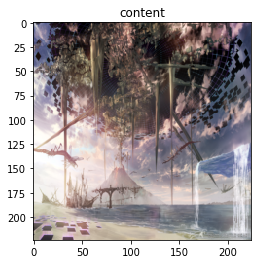

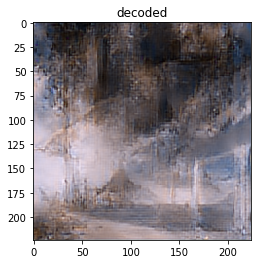

C:\tool\python\lib\site-packages\ipykernel_launcher.py:33: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


In [2]:
from keras.models import Model, Sequential, load_model
from keras.preprocessing import image
import numpy as np
from scipy.misc import imsave,imresize
from matplotlib import pyplot as plt

DECODER_PATH = './decoder_5.h5'
INPUT_IMG_PATH = './content.jpg'
OUTPUT_IMG_PATH = './content-decoded.jpg'
print('Loading decoders...')
decoders= load_model(DECODER_PATH)

print('Loading VGG...')
input_shape=(224, 224, 3)
vgg = VGG19(input_shape=input_shape, target_layer=5)
model = Sequential()
model.add(vgg)
model.add(decoders)
encoder_decoder = model

input_img = image.load_img(INPUT_IMG_PATH)
input_img = imresize(input_img, (224, 224, 3))
input_img = image.img_to_array(input_img)
input_img = np.expand_dims(input_img, axis=0)

output_img = encoder_decoder.model.predict([input_img])[0]
plt.title('content')
plt.imshow(np.clip(input_img[0] / 255, 0, 1))
plt.show()
plt.title('decoded')
plt.imshow(np.clip(output_img/ 255, 0, 1))
plt.show()
imsave(OUTPUT_IMG_PATH, output_img)

Loading decoders...


C:\tool\python\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Loading VGG...


C:\tool\python\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
C:\tool\python\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


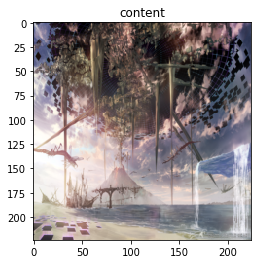

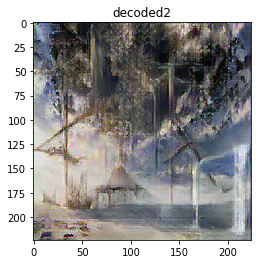

C:\tool\python\lib\site-packages\ipykernel_launcher.py:33: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


In [3]:
from keras.models import Model, Sequential, load_model
from keras.preprocessing import image
import numpy as np
from scipy.misc import imsave,imresize
from matplotlib import pyplot as plt

DECODER_PATH = './decoder_4.h5'
INPUT_IMG_PATH = './content.jpg'
OUTPUT_IMG_PATH = './content-decoded.jpg'
print('Loading decoders...')
decoders= load_model(DECODER_PATH)

print('Loading VGG...')
input_shape=(224, 224, 3)
vgg = VGG19(input_shape=input_shape, target_layer=4)
model = Sequential()
model.add(vgg)
model.add(decoders)
encoder_decoder = model

input_img = image.load_img(INPUT_IMG_PATH)
input_img = imresize(input_img, (224, 224, 3))
input_img = image.img_to_array(input_img)
input_img = np.expand_dims(input_img, axis=0)

output_img = encoder_decoder.model.predict([input_img])[0]
plt.title('content')
plt.imshow(np.clip(input_img[0] / 255, 0, 1))
plt.show()
plt.title('decoded2')
plt.imshow(np.clip(output_img/ 255, 0, 1))
plt.show()
imsave(OUTPUT_IMG_PATH, output_img)

This decoder is not a perfect decoder but i still use 12 hour per decoder（5000 iteration） to train it....

# 9.Implement the whitening and coloring transform

Implement the whitening and coloring transform as described by Li et al. 

C:\tool\python\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
C:\tool\python\lib\site-packages\ipykernel_launcher.py:77: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Loading decoders...


C:\tool\python\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Loading VGG...


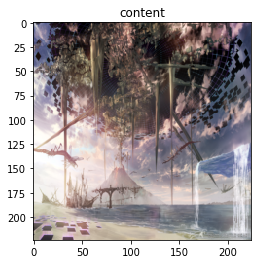

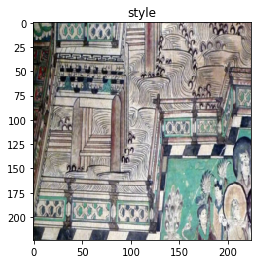

Styling...


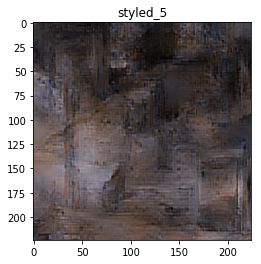

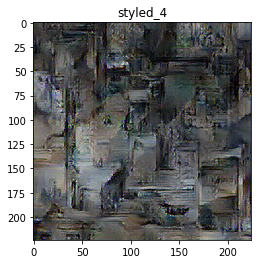

Saving output...


C:\tool\python\lib\site-packages\ipykernel_launcher.py:115: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


In [8]:
import sys

from keras.models import load_model
from keras.preprocessing import image
from keras import backend as K
import numpy as np
from scipy.misc import imresize, imsave

def get_vgg_features(vgg, inputs, target_layer):
    output_layers = [
            'block1_conv1',
            'block2_conv1',
            'block3_conv1',
            'block4_conv1',
            'block5_conv1'
    ]

    outputs = [layer.output for layer in vgg.layers
               if layer.name == output_layers[target_layer-1]]
    f = K.function([vgg.input] + [K.learning_phase()], outputs)
    return f([inputs, 1.])


def wct(content, style, alpha=0.6, eps=1e-5):
    '''
    https://github.com/eridgd/WCT-TF/blob/master/ops.py
       Perform Whiten-Color Transform on feature maps using numpy
       See p.4 of the Universal Style Transfer paper for equations:
       https://arxiv.org/pdf/1705.08086.pdf
    '''
    # 1xHxWxC -> CxHxW
    content_t = np.transpose(np.squeeze(content), (2, 0, 1))
    style_t = np.transpose(np.squeeze(style), (2, 0, 1))

    # CxHxW -> CxH*W
    content_flat = content_t.reshape(-1, content_t.shape[1]*content_t.shape[2])
    style_flat = style_t.reshape(-1, style_t.shape[1]*style_t.shape[2])

    # Whitening transform
    mc = content_flat.mean(axis=1, keepdims=True)
    fc = content_flat - mc
    fcfc = np.dot(fc, fc.T) / (content_t.shape[1]*content_t.shape[2] - 1)
    Ec, wc, _ = np.linalg.svd(fcfc)
    k_c = (wc > 1e-5).sum()
    Dc = np.diag((wc[:k_c]+eps)**-0.5)
    fc_hat = Ec[:,:k_c].dot(Dc).dot(Ec[:,:k_c].T).dot(fc)

    # Coloring transform
    ms = style_flat.mean(axis=1, keepdims=True)
    fs = style_flat - ms
    fsfs = np.dot(fs, fs.T) / (style_t.shape[1]*style_t.shape[2] - 1)
    Es, ws, _ = np.linalg.svd(fsfs)
    k_s = (ws > 1e-5).sum()
    Ds = np.sqrt(np.diag(ws[:k_s]+eps))
    fcs_hat = Es[:,:k_s].dot(Ds).dot(Es[:,:k_s].T).dot(fc_hat)
    fcs_hat = fcs_hat + ms

    # Blend transform features with original features
    blended = alpha*fcs_hat + (1 - alpha)*(fc)

    # CxH*W -> CxHxW
    blended = blended.reshape(content_t.shape)
    # CxHxW -> 1xHxWxC
    blended = np.expand_dims(np.transpose(blended, (1,2,0)), 0)

    return np.float32(blended)



img_c = image.load_img('./content.jpg')
img_c = imresize(img_c, (224, 224, 3))
img_c = image.img_to_array(img_c)
img_c_shape = img_c.shape
img_c = np.expand_dims(img_c, axis=0)

img_s = image.load_img('./style.jpg')
img_s = imresize(img_s, (224, 224, 3))
img_s = image.img_to_array(img_s)
img_s_shape = img_s.shape
img_s = np.expand_dims(img_s, axis=0)

assert img_c_shape == img_s_shape, \
    'Content and style image should be the same shape, %s != %s' \
    % (str(img_c_shape), str(img_s_shape))

input_shape = img_c_shape

print('Loading decoders...')
decoders = {}
decoders[4] = load_model('./decoder_4.h5')
decoders[5] = load_model('./decoder_5.h5')

print('Loading VGG...')
vgg = VGG19(input_shape=input_shape, target_layer=5)

import matplotlib.pyplot as plt
plt.title('content')
plt.imshow(np.clip(img_c[0] / 255, 0, 1))
plt.show()
plt.title('style')
plt.imshow(np.clip(img_s[0] / 255, 0, 1))
plt.show()

print('Styling...')
for i in [5, 4]:
    feats_c = get_vgg_features(vgg, img_c, i)
    feats_s = get_vgg_features(vgg, img_s, i)
    feats_cs = wct(feats_c, feats_s)
    img_c = decoders[i].predict(feats_cs)
    plt.title('styled_%s'%i)
    plt.imshow(np.clip(img_c[0] / 255, 0, 1))
    plt.show()

print('Saving output...')
output_img = img_c[0]

imsave('./styled_content.jpg', output_img)

After training i find another great way to train the model,  

in the following link, this author firstly let the training image go through vgg19 and store the output feature map as the input for decoder, and then combine another vgg19 model with the decoder, that means, not encoder-decoder but decoder-encoder,  
in my opinion, this method will speed up the decoder convergence.  
https://github.com/abhijith97/Universal-Style-Transfer/blob/master/train_decoder.py

# 10.Another way for WCT with tensorflow

In order to learn some tensorflow code, i find another version of WCT and another way to build style-transfer,  
the whole code link is following and i just focus on the WCT part.
https://github.com/eridgd/WCT-TF


In [19]:

import tensorflow as tf

def wct_tf(content, style, alpha=0.5, eps=1e-8):
    '''TensorFlow version of Whiten-Color Transform
       Assume that content/style encodings have shape 1xHxWxC
       See p.4 of the Universal Style Transfer paper for corresponding equations:
       https://arxiv.org/pdf/1705.08086.pdf
    '''
    # Remove batch dim and reorder to CxHxW
    content_t = tf.transpose(tf.squeeze(content), (2, 0, 1))
    style_t = tf.transpose(tf.squeeze(style), (2, 0, 1))

    Cc, Hc, Wc = tf.unstack(tf.shape(content_t))
    Cs, Hs, Ws = tf.unstack(tf.shape(style_t))

    # CxHxW -> CxH*W
    content_flat = tf.reshape(content_t, (Cc, Hc*Wc))
    style_flat = tf.reshape(style_t, (Cs, Hs*Ws))

    # Content covariance
    mc = tf.reduce_mean(content_flat, axis=1, keep_dims=True)
    fc = content_flat - mc
    fcfc = tf.matmul(fc, fc, transpose_b=True) / (tf.cast(Hc*Wc, tf.float32) - 1.) + tf.eye(Cc)*eps

    # Style covariance
    ms = tf.reduce_mean(style_flat, axis=1, keep_dims=True)
    fs = style_flat - ms
    fsfs = tf.matmul(fs, fs, transpose_b=True) / (tf.cast(Hs*Ws, tf.float32) - 1.) + tf.eye(Cs)*eps

    # tf.svd is slower on GPU, see https://github.com/tensorflow/tensorflow/issues/13603
    with tf.device('/cpu:0'):  
        Sc, Uc, _ = tf.svd(fcfc)
        Ss, Us, _ = tf.svd(fsfs)



    # Filter small singular values
    k_c = tf.reduce_sum(tf.cast(tf.greater(Sc, 1e-5), tf.int32))
    k_s = tf.reduce_sum(tf.cast(tf.greater(Ss, 1e-5), tf.int32))

    # Whiten content feature
    Dc = tf.diag(tf.pow(Sc[:k_c], -0.5))
    fc_hat = tf.matmul(tf.matmul(tf.matmul(Uc[:,:k_c], Dc), Uc[:,:k_c], transpose_b=True), fc)

    # Color content with style
    Ds = tf.diag(tf.pow(Ss[:k_s], 0.5))
    fcs_hat = tf.matmul(tf.matmul(tf.matmul(Us[:,:k_s], Ds), Us[:,:k_s], transpose_b=True), fc_hat)

    # Re-center with mean of style
    fcs_hat = fcs_hat + ms

    # Blend whiten-colored feature with original content feature
    blended = alpha * fcs_hat + (1 - alpha) * (fc + mc)

    # CxH*W -> CxHxW
    blended = tf.reshape(blended, (Cc,Hc,Wc))
    # CxHxW -> 1xHxWxC
    blended = tf.expand_dims(tf.transpose(blended, (1,2,0)), 0)

    return blended

def Adain(content,style,eps=1e-8):
    mean_c, var_c = tf.nn.moments(content,axes=[1,2],keep_dims= True)
    mean_s, var_s = tf.nn.moments(style,axes=[1,2],keep_dims=True)
    
    instance_normolization = (content -mean_c) / (var_c+eps)
    
    stylized_feature = instance_normolization*var_s+mean_s
    
    return stylized_feature

# 11. photo transfer

I find two way to do this task:  
A Closed-form Solution to Photorealistic Image Stylization  
https://arxiv.org/pdf/1802.06474.pdf  

Deep photo style transfer  
https://arxiv.org/pdf/1703.07511.pdf  
All of them use smooth(filter) method at the end of the model, and there are further step on mask photo transfer which is not necessary for our lab.

this smooth method is not a neural network method,  
it is similar to WCT,  
the main idea is to add the missed detail content in image to the output image  
to get a more clear output

In [ ]:
import sys

from keras.models import load_model
from keras.preprocessing import image
from keras import backend as K
import numpy as np
from scipy.misc import imresize, imsave

def get_vgg_features(vgg, inputs, target_layer):
    output_layers = [
            'block1_conv1',
            'block2_conv1',
            'block3_conv1',
            'block4_conv1',
            'block5_conv1'
    ]

    outputs = [layer.output for layer in vgg.layers
               if layer.name == output_layers[target_layer-1]]
    f = K.function([vgg.input] + [K.learning_phase()], outputs)
    return f([inputs, 1.])


def wct(content, style, alpha=0.6, eps=1e-5):
    '''
    https://github.com/eridgd/WCT-TF/blob/master/ops.py
       Perform Whiten-Color Transform on feature maps using numpy
       See p.4 of the Universal Style Transfer paper for equations:
       https://arxiv.org/pdf/1705.08086.pdf
    '''
    # 1xHxWxC -> CxHxW
    content_t = np.transpose(np.squeeze(content), (2, 0, 1))
    style_t = np.transpose(np.squeeze(style), (2, 0, 1))

    # CxHxW -> CxH*W
    content_flat = content_t.reshape(-1, content_t.shape[1]*content_t.shape[2])
    style_flat = style_t.reshape(-1, style_t.shape[1]*style_t.shape[2])

    # Whitening transform
    mc = content_flat.mean(axis=1, keepdims=True)
    fc = content_flat - mc
    fcfc = np.dot(fc, fc.T) / (content_t.shape[1]*content_t.shape[2] - 1)
    Ec, wc, _ = np.linalg.svd(fcfc)
    k_c = (wc > 1e-5).sum()
    Dc = np.diag((wc[:k_c]+eps)**-0.5)
    fc_hat = Ec[:,:k_c].dot(Dc).dot(Ec[:,:k_c].T).dot(fc)

    # Coloring transform
    ms = style_flat.mean(axis=1, keepdims=True)
    fs = style_flat - ms
    fsfs = np.dot(fs, fs.T) / (style_t.shape[1]*style_t.shape[2] - 1)
    Es, ws, _ = np.linalg.svd(fsfs)
    k_s = (ws > 1e-5).sum()
    Ds = np.sqrt(np.diag(ws[:k_s]+eps))
    fcs_hat = Es[:,:k_s].dot(Ds).dot(Es[:,:k_s].T).dot(fc_hat)
    fcs_hat = fcs_hat + ms

    # Blend transform features with original features
    blended = alpha*fcs_hat + (1 - alpha)*(fc)

    # CxH*W -> CxHxW
    blended = blended.reshape(content_t.shape)
    # CxHxW -> 1xHxWxC
    blended = np.expand_dims(np.transpose(blended, (1,2,0)), 0)

    return np.float32(blended)

In [ ]:
from __future__ import division
import torch.nn as nn
import scipy.misc
import numpy as np
import scipy.sparse
import scipy.sparse.linalg
from numpy.lib.stride_tricks import as_strided
from PIL import Image


class Propagator(nn.Module):
    def __init__(self, beta=0.9999):
        super(Propagator, self).__init__()
        self.beta = beta

    def process(self, initImg, contentImg):

        if type(contentImg) == str:
            content = scipy.misc.imread(contentImg, mode='RGB')
        else:
            content = contentImg.copy()
        # content = scipy.misc.imread(contentImg, mode='RGB')

        if type(initImg) == str:
            B = scipy.misc.imread(initImg, mode='RGB').astype(np.float64) / 255
        else:
            B = scipy.asarray(initImg).astype(np.float64) / 255
            # B = self.
        # B = scipy.misc.imread(initImg, mode='RGB').astype(np.float64)/255
        h1,w1,k = B.shape
        h = h1 - 4
        w = w1 - 4
        B = B[int((h1-h)/2):int((h1-h)/2+h),int((w1-w)/2):int((w1-w)/2+w),:]
        content = scipy.misc.imresize(content,(h,w))
        B = self.__replication_padding(B,2)
        content = self.__replication_padding(content,2)
        content = content.astype(np.float64)/255
        B = np.reshape(B,(h1*w1,k))
        W = self.__compute_laplacian(content)
        W = W.tocsc()
        dd = W.sum(0)
        dd = np.sqrt(np.power(dd,-1))
        dd = dd.A.squeeze()
        D = scipy.sparse.csc_matrix((dd, (np.arange(0,w1*h1), np.arange(0,w1*h1)))) # 0.026
        S = D.dot(W).dot(D)
        A = scipy.sparse.identity(w1*h1) - self.beta*S
        A = A.tocsc()
        solver = scipy.sparse.linalg.factorized(A)
        V = np.zeros((h1*w1,k))
        V[:,0] = solver(B[:,0])
        V[:,1] = solver(B[:,1])
        V[:,2] = solver(B[:,2])
        V = V*(1-self.beta)
        V = V.reshape(h1,w1,k)
        V = V[2:2+h,2:2+w,:]
        
        img = Image.fromarray(np.uint8(np.clip(V * 255., 0, 255.)))
        return img

    # Returns sparse matting laplacian
    # The implementation of the function is heavily borrowed from
    # https://github.com/MarcoForte/closed-form-matting/blob/master/closed_form_matting.py
    # We thank Marco Forte for sharing his code.
    def __compute_laplacian(self, img, eps=10**(-7), win_rad=1):
            win_size = (win_rad*2+1)**2
            h, w, d = img.shape
            c_h, c_w = h - 2*win_rad, w - 2*win_rad
            win_diam = win_rad*2+1
            indsM = np.arange(h*w).reshape((h, w))
            ravelImg = img.reshape(h*w, d)
            win_inds = self.__rolling_block(indsM, block=(win_diam, win_diam))
            win_inds = win_inds.reshape(c_h, c_w, win_size)
            winI = ravelImg[win_inds]
            win_mu = np.mean(winI, axis=2, keepdims=True)
            win_var = np.einsum('...ji,...jk ->...ik', winI, winI)/win_size - np.einsum('...ji,...jk ->...ik', win_mu, win_mu)
            inv = np.linalg.inv(win_var + (eps/win_size)*np.eye(3))
            X = np.einsum('...ij,...jk->...ik', winI - win_mu, inv)
            vals = (1/win_size)*(1 + np.einsum('...ij,...kj->...ik', X, winI - win_mu))
            nz_indsCol = np.tile(win_inds, win_size).ravel()
            nz_indsRow = np.repeat(win_inds, win_size).ravel()
            nz_indsVal = vals.ravel()
            L = scipy.sparse.coo_matrix((nz_indsVal, (nz_indsRow, nz_indsCol)), shape=(h*w, h*w))
            return L

    def __replication_padding(self, arr,pad):
            h,w,c = arr.shape
            ans = np.zeros((h+pad*2,w+pad*2,c))
            for i in range(c):
                    ans[:,:,i] = np.pad(arr[:,:,i],pad_width=(pad,pad),mode='edge')
            return ans

    def __rolling_block(self, A, block=(3, 3)):
        shape = (A.shape[0] - block[0] + 1, A.shape[1] - block[1] + 1) + block
        strides = (A.strides[0], A.strides[1]) + A.strides
        return as_strided(A, shape=shape, strides=strides)

In [ ]:
img_c = image.load_img('../input/dataset/0.jpg')
img_c = imresize(img_c, (224, 224, 3))
img_c = image.img_to_array(img_c)
img_c_shape = img_c.shape
img_c = np.expand_dims(img_c, axis=0)

img_s = image.load_img('../input/dataset/0s.jpg')
img_s = imresize(img_s, (224, 224, 3))
img_s = image.img_to_array(img_s)
img_s_shape = img_s.shape
img_s = np.expand_dims(img_s, axis=0)


assert img_c_shape == img_s_shape, \
    'Content and style image should be the same shape, %s != %s' \
    % (str(img_c_shape), str(img_s_shape))

input_shape = img_c_shape

print('Loading decoders...')
decoders = {}
decoders[4] = load_model('./decoder_4.h5')
decoders[5] = load_model('./decoder_5.h5')

print('Loading VGG...')
vgg = VGG19(input_shape=input_shape, target_layer=5)

import matplotlib.pyplot as plt
plt.title('content')
plt.imshow(np.clip(img_c[0] / 255, 0, 1))
plt.show()
plt.title('style')
plt.imshow(np.clip(img_s[0] / 255, 0, 1))
plt.show()

print('Styling...')
for i in [5, 4]:
    feats_c = get_vgg_features(vgg, img_c, i)
    feats_s = get_vgg_features(vgg, img_s, i)
    feats_cs = wct(feats_c, feats_s)
    img_c = decoders[i].predict(feats_cs)
    plt.title('styled_%s'%i)
    plt.imshow(np.clip(img_c[0] / 255, 0, 1))
    plt.show()

print('Saving output...')
output_img = img_c[0]
output_image_path = './styled_content.jpg'
content_image_path = '../input/dataset/1.jpg'
imsave(output_image_path , output_img)
p_pro = Propagator(0.9)
out_img = p_pro.process( output_image_path , content_image_path)
imsave('./styled_photo.jpg', out_img)
out_img = image.img_to_array(out_img)
plt.title('styled_photo')
plt.imshow(np.clip(out_img / 255., 0, 1))
plt.show()